In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import copy
import time

import torch
from torch import nn
from torchsummary import summary
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [ ]:
import hc_utils as utils

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
data32 = utils.load_data('./data/heat_cond_data_n32_new.pickle', normalize=True)
train_loader32, test_loader32 = utils.get_data_loaders(data32, test_size=0.5, batch_size=128, training_noise=False)
test_data = utils.load_data('./data/heat_cond_data_n64.pickle', normalize=True)
train_loader64, test_loader64 = utils.get_data_loaders(test_data, test_size=0.2, batch_size=8, training_noise=False, normalize=False, random_state=21)
test_loader = DataLoader(utils.HeatConductionDataset(test_data, noise=None), batch_size=1)

In [ ]:
len(train_loader32.dataset), len(test_loader32.dataset)

(1024, 1024)

In [ ]:
with open('./data/heat_cond_data_n64.pickle', mode='rb') as input_file:
        td = pickle.load(input_file)

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, in_channels=2, out_features=4, bn=False, af=nn.ReLU(), transform_output=False):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=4, kernel_size=3, padding='same', padding_mode='reflect'),
            nn.BatchNorm2d(num_features=4),
            af,
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding='same', padding_mode='reflect'),
            nn.BatchNorm2d(num_features=8),
            af,
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding='same', padding_mode='reflect'),
            nn.BatchNorm2d(num_features=16),
            af,
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same', padding_mode='reflect'),
            nn.BatchNorm2d(num_features=32),
            af,
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same', padding_mode='reflect'),
            nn.BatchNorm2d(num_features=64),
            af,
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same', padding_mode='reflect'),
            nn.BatchNorm2d(num_features=128),
            af,
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding='same', padding_mode='reflect'),
            nn.BatchNorm2d(num_features=256),
            af,
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=1)
        
        self.fc = nn.Linear(in_features=256, out_features=out_features)

        self.transform_output = transform_output
        
    def forward(self, x):
        y = self.conv(x)
        y = self.avgpool(y)
        y = torch.flatten(y, start_dim=1)
        y = self.fc(y)

        if self.transform_output:
            y = nn.functional.sigmoid(y)

        return y

In [ ]:
class DownConvBlock(nn.Module):
    def __init__(self, in_channels, factor=2, negative_slope=0.2):
        super().__init__()
        
        self.conv0 = nn.Conv2d(in_channels=in_channels, out_channels=4*in_channels, kernel_size=3, padding='same', padding_mode='reflect')
        self.bn0 = nn.BatchNorm2d(num_features = 4*in_channels)
        
        self.conv1 = nn.Conv2d(in_channels=4*in_channels, out_channels=8*in_channels, kernel_size=3, padding='same', padding_mode='reflect')
        self.bn1 = nn.BatchNorm2d(num_features = 8*in_channels)
        
        self.conv2 = nn.Conv2d(in_channels=8*in_channels, out_channels=factor*in_channels, kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm2d(num_features = factor*in_channels)
        
        self.lrelu = nn.LeakyReLU(negative_slope=0.2)
        self.downsample = nn.AvgPool2d(kernel_size=2, stride=2)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        y = self.lrelu(self.conv0(x))
        y = self.lrelu(self.conv1(y))
        y = self.lrelu(self.conv2(y))
        
        y = y + self.downsample(x)
        return y        

In [ ]:
class HCEncoder(nn.Module):
    def __init__(self, n_layers=5, in_channels=2, factor=2, negative_slope=0.2):
        super().__init__()
        
        layers = []
        
        for i in range(n_layers):
            layers.append(DownConvBlock(in_channels=in_channels*factor**i, factor=factor, negative_slope=negative_slope))
        
        self.blocks = nn.Sequential(*layers)
           
    def forward(self, x):
        return self.blocks(x)

In [ ]:
class UpConvBlock(nn.Module):
    def __init__(self, in_channels, factor=2, negative_slope=0.2):
        super().__init__()
        
        self.conv0 = nn.ConvTranspose2d(in_channels=in_channels, out_channels=8*in_channels, kernel_size=2, stride=2)
        self.bn0 = nn.BatchNorm2d(num_features = 8*in_channels)
        
        self.conv1 = nn.Conv2d(in_channels=8*in_channels, out_channels=4*in_channels, kernel_size=3, padding='same', padding_mode='reflect')
        self.bn1 = nn.BatchNorm2d(num_features = 4*in_channels)
        
        self.conv2 = nn.Conv2d(in_channels=4*in_channels, out_channels=int(in_channels/factor), kernel_size=3, padding='same', padding_mode='reflect')
        self.bn2 = nn.BatchNorm2d(num_features = int(in_channels/factor))

        self.lrelu = nn.LeakyReLU(negative_slope=0.2)
        self.upsample = nn.Upsample(scale_factor = 2, mode='bilinear')
        
    def forward(self, x):
        y = self.lrelu(self.bn0(self.conv0(x)))
        y = self.lrelu(self.bn1(self.conv1(y)))
        y = self.lrelu(self.bn2(self.conv2(y)))
        #return self.upsample(x)        
        return y  + self.upsample(x)

In [ ]:
class HCDecoder(nn.Module):
    def __init__(self, n_layers=5, in_channels=32, factor=2, negative_slope=0.2):
        super().__init__()
        
        layers = []
        
        for i in range(n_layers):
            layers.append(UpConvBlock(in_channels=int(in_channels/factor**i), factor=factor, negative_slope=negative_slope))
        
        self.blocks = nn.Sequential(*layers)
           
    def forward(self, x):
        return self.blocks(x)

In [ ]:
class HCAutoEncoder(nn.Module):
    def __init__(self, regressor=None, n_layers=4, in_channels=2, factor=2, negative_slope=0.2, denoising=False):
        super().__init__()
        
        self.denoising = denoising
        
        self.encoder = HCEncoder(n_layers=n_layers, in_channels=in_channels, factor=factor, negative_slope=negative_slope)
        
        self.decoder = HCDecoder(n_layers=n_layers, in_channels=int(in_channels*factor**n_layers), factor=factor, negative_slope=negative_slope)
        
        self.regressor = regressor
           
    def forward(self, x):
        if self.denoising:
            x += np.random.normal(0, 0.1, size=x.shape)
            
        latent = self.encoder(x)
        reconst = self.decoder(latent)
        y = self.regressor(latent) if self.regressor else None
        return latent, reconst, y

In [ ]:
convnet = torch.load('./models/convnet32_3.model')

In [ ]:
summary(convnet.float(), (2,16,16))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 16, 16]              76
       BatchNorm2d-2            [-1, 4, 16, 16]               8
              ReLU-3            [-1, 4, 16, 16]               0
            Conv2d-4            [-1, 8, 16, 16]             296
       BatchNorm2d-5            [-1, 8, 16, 16]              16
              ReLU-6            [-1, 8, 16, 16]               0
         MaxPool2d-7              [-1, 8, 8, 8]               0
            Conv2d-8             [-1, 16, 8, 8]           1,168
       BatchNorm2d-9             [-1, 16, 8, 8]              32
             ReLU-10             [-1, 16, 8, 8]               0
           Conv2d-11             [-1, 32, 8, 8]           4,640
      BatchNorm2d-12             [-1, 32, 8, 8]              64
             ReLU-13             [-1, 32, 8, 8]               0
        MaxPool2d-14             [-1, 3

In [ ]:
summary(HCAutoEncoder(convnet.float(), in_channels=2, n_layers=1, factor=1), (2,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             152
         LeakyReLU-2            [-1, 8, 32, 32]               0
            Conv2d-3           [-1, 16, 32, 32]           1,168
         LeakyReLU-4           [-1, 16, 32, 32]               0
            Conv2d-5            [-1, 2, 16, 16]             130
         LeakyReLU-6            [-1, 2, 16, 16]               0
         AvgPool2d-7            [-1, 2, 16, 16]               0
     DownConvBlock-8            [-1, 2, 16, 16]               0
         HCEncoder-9            [-1, 2, 16, 16]               0
  ConvTranspose2d-10           [-1, 16, 32, 32]             144
      BatchNorm2d-11           [-1, 16, 32, 32]              32
        LeakyReLU-12           [-1, 16, 32, 32]               0
           Conv2d-13            [-1, 8, 32, 32]           1,160
      BatchNorm2d-14            [-1, 8,

In [ ]:
class HCLoss(nn.Module):
    def __init__(self, alpha=1):
        super().__init__()
        
        self.alpha = alpha
        self.metric = nn.MSELoss()
        
    def forward(self, x, x_hat, y, y_hat):
        #return 2*self.metric(y[:,0], y_hat[:,0]) + self.metric(y[:,0:], y_hat[:,0:]) + self.alpha*self.metric(x, x_hat)
        return self.metric(y, y_hat) + self.alpha*self.metric(x, x_hat)

In [ ]:
def epoch_step(model, dataloader, loss_fn, optimizer, device, train=True):
    losses = []
    
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)

        if train:
            optimizer.zero_grad()
            l, x_hat, y_hat = model(x)
        else:
            with torch.no_grad():
                l, x_hat, y_hat = model(x)
                
        loss = loss_fn(x, x_hat, y, y_hat) if not y_hat is None else loss_fn(x, x_hat)

        losses.append(loss.item())

        if train:
            loss.backward()
            optimizer.step()
            
    return losses

In [ ]:
def epoch_step_test(model, dataloader, loss_fn, optimizer, device, train=True):
    losses = []
    
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)

        if train:
            optimizer.zero_grad()
            preds = model(x)
        else:
            with torch.no_grad():
                preds = model(x)

        loss = loss_fn(preds, y)

        losses.append(loss.item())

        if train:
            loss.backward()
            optimizer.step()
            
    return losses

In [ ]:
def train_model(model, traindata, valdata, loss_fn, optimizer, device, n_epoch, testdata=None, test_regressor=None, prog_bar_desc='Epochs', early_stop=False, patience=10, warmup=10):
    train_losses, valid_losses, test_losses = [], [], []
    model = model.to(device)
    patience_counter = 0
    min_loss = 1
    best_model = None

    for i in tqdm(range(n_epoch), desc=prog_bar_desc):
        model.train()
        epoch_losses = epoch_step(model, traindata, loss_fn, optimizer, device, train=True)
        train_losses.append(np.mean(epoch_losses))

        model.eval()
        epoch_losses = epoch_step(model, valdata, loss_fn, optimizer, device, train=False)
        valid_losses.append(np.mean(epoch_losses))

        if testdata and test_regressor:
            predictor = nn.Sequential(model.encoder, test_regressor)
            epoch_losses = epoch_step_test(predictor, testdata, nn.MSELoss(), None, device, train=False)
            test_losses.append(np.mean(epoch_losses))

        if early_stop:
            if i > warmup and valid_losses[-1] < min_loss:
                patience_counter = 0
                min_loss = valid_losses[-1]
                best_model = copy.deepcopy(model)
            elif patience_counter > patience:
                break
            elif i > warmup:
                patience_counter += 1

    return train_losses, valid_losses, test_losses, best_model

In [ ]:
alphas = [0.01, 0.05, 0.1, 0.2, 1]
denoisings = [False]

In [ ]:
results = []
models = []
n_epoch = 500

for alpha in alphas:
    for denoising in denoisings:
        convnet = torch.load('./models/convnet32_3.model')
        model = HCAutoEncoder(in_channels=2, n_layers=1, factor=1, denoising=denoising).double()
        sgd0 = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-1)
        criterion0 = nn.MSELoss()
        

        start_time = time.time()
        #train_losses0, valid_losses0, model = train_model(model, train_loader64, test_loader64, criterion0, sgd0, device, 100, early_stop=True, patience=5)
        model.regressor = copy.deepcopy(convnet)
        for param in model.regressor.parameters():
            param.grad = None
            param.requires_grad = False
        sgd = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01, momentum=0.9, weight_decay=1e-3)
        criterion = HCLoss(alpha=alpha)
        train_losses1, valid_losses1, _, model = train_model(model, train_loader32, test_loader32, criterion, sgd, device, n_epoch, early_stop=True, patience=5)
        model.requires_grad_(True)
        # for param_group in sgd.param_groups:
        #     param_group['lr'] = 0.001
        sgd = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-3)
        train_losses_fn, valid_losses_fn, _, model = train_model(model, train_loader32, test_loader32, criterion, sgd, device, n_epoch, early_stop=True, patience=5)
        end_time = time.time()

        warmup = np.argmin(valid_losses1)
        finish = np.argmin(valid_losses_fn)
        train_losses = train_losses1[:warmup+1] + train_losses_fn[:finish+1]
        valid_losses = valid_losses1[:warmup+1] + valid_losses_fn[:finish+1]

        predictor = nn.Sequential(
            model.encoder,
            convnet
        )
        test_ev = utils.Evaluator(predictor, dataset=test_data)
        test_loss = test_ev.calculate_loss()

        results.append((alpha, denoising, train_losses, valid_losses, warmup, end_time-start_time, test_loss))
        models.append((alpha, model))

Epochs:  51%|████████████████████████████████████▊                                   | 256/500 [16:01<15:15,  3.75s/it]


In [ ]:
results = []
models = []
n_epoch = 500

for alpha in alphas:
    for denoising in denoisings:
        convnet = torch.load('./models/convnet32_3.model')
        model = HCAutoEncoder(ConvNet(bn=True, af=nn.ReLU(), transform_output=True), in_channels=2, n_layers=1, factor=1, denoising=denoising).double()
        sgd0 = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-1)
        criterion0 = nn.MSELoss()
        

        start_time = time.time()
        #train_losses0, valid_losses0, model = train_model(model, train_loader64, test_loader64, criterion0, sgd0, device, 100, early_stop=True, patience=5)
       
        sgd = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01, momentum=0.9, weight_decay=1e-3)
        criterion = HCLoss(alpha=alpha)
        train_losses, valid_losses, test_losses, model = train_model(model, train_loader32, test_loader32, criterion, sgd, device, n_epoch, testdata=test_loader, test_regressor=convnet, early_stop=True, warmup=5, patience=10)
        end_time = time.time()

        results.append((alpha, denoising, train_losses, valid_losses, test_losses, end_time-start_time))
        models.append((alpha, model))

Epochs:   9%|██████▋                                                                  | 46/500 [02:33<25:14,  3.34s/it]


In [ ]:
results0 = []
models0 = []
n_epoch = 500

for alpha in alphas:
    for denoising in denoisings:
        convnet = torch.load('./models/convnet32_3.model')
        model = HCAutoEncoder(ConvNet(bn=True, af=nn.ReLU(), transform_output=True), in_channels=2, n_layers=1, factor=1, denoising=denoising).double()
        sgd0 = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-1)
        criterion0 = nn.MSELoss()
        

        start_time = time.time()
        #train_losses0, valid_losses0, _,  model = train_model(model, train_loader64, test_loader64, criterion0, sgd0, device, 100, early_stop=True, patience=5)
       
        sgd = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01, momentum=0.9, weight_decay=1e-3)
        criterion = HCLoss(alpha=alpha)
        train_losses, valid_losses, test_losses, model = train_model(model, train_loader32, test_loader32, criterion, sgd, device, n_epoch, testdata=test_loader, test_regressor=convnet, early_stop=True, warmup=5, patience=10)
        end_time = time.time()

        results0.append((alpha, denoising, train_losses, valid_losses, test_losses, end_time-start_time))
        models0.append((alpha, model))

Epochs:  23%|████████████████▍                                                       | 114/500 [07:58<27:01,  4.20s/it]


In [ ]:
results2 = []
models2 = []
n_epoch = 500

for alpha in alphas:
    for denoising in denoisings:
        convnet = torch.load('./models/convnet32_3.model')
        model = HCAutoEncoder(in_channels=2, n_layers=1, factor=1, denoising=denoising).double()
        sgd0 = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-1)
        criterion0 = nn.MSELoss()
        

        start_time = time.time()
        train_losses0, valid_losses0, _,  model = train_model(model, train_loader64, test_loader64, criterion0, sgd0, device, 100, early_stop=True, patience=5)
        model.regressor=ConvNet(bn=True, af=nn.ReLU(), transform_output=True).double()
        sgd = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01, momentum=0.9, weight_decay=1e-3)
        criterion = HCLoss(alpha=alpha)
        train_losses, valid_losses, test_losses, model = train_model(model, train_loader32, test_loader32, criterion, sgd, device, n_epoch, testdata=test_loader, test_regressor=convnet, early_stop=True, warmup=5, patience=10)
        end_time = time.time()

        results2.append((alpha, denoising, train_losses, valid_losses, test_losses, end_time-start_time))
        models2.append((alpha, model))

Epochs:  10%|███████▍                                                                 | 51/500 [03:38<32:00,  4.28s/it]


In [ ]:
df = pd.DataFrame(results, columns=['alpha', 'denoising', 'train_losses', 'valid_losses', 'test_losses', 'exec_time'])
df['epochs'] = df.valid_losses.apply(lambda x: len(x))
df['min_loss'] = df.test_losses.apply(lambda x: np.min(x[10:]))
df['unit_time'] = df.exec_time / df.epochs
df

,alpha,denoising,train_losses,valid_losses,test_losses,exec_time,epochs,min_loss,unit_time
0,0.01,False,"[0.17641831479661665, 0.1204215723484082, 0.08...","[0.21221859356178624, 0.20439636111556653, 0.2...","[0.00809908162831846, 0.008238143543636056, 0....",152.854381,45,0.011900,3.396764
1,0.05,False,"[0.20064236471367247, 0.14160729439986658, 0.0...","[0.21522809473595228, 0.19484879073422307, 0.1...","[0.01682969261586348, 0.01754157128343098, 0.0...",348.598795,113,0.004766,3.084945
2,0.10,False,"[0.18782014311007567, 0.1421595656495553, 0.11...","[0.21140419140038796, 0.19192056722417233, 0.1...","[0.06529276732261056, 0.059487959134779854, 0....",293.896492,91,0.002103,3.229632
3,0.20,False,"[0.1787486014322664, 0.11428345792265641, 0.07...","[0.2262619692338966, 0.2619569302483643, 0.359...","[0.002440473012506479, 0.0026970562915367927, ...",133.433994,42,0.012810,3.177000
4,1.00,False,"[0.186942330301406, 0.11629229865733672, 0.070...","[0.22381575055711464, 0.22727828462317184, 0.3...","[0.05775073709323357, 0.03615628012073534, 0.0...",153.503589,47,0.024068,3.266034


In [ ]:
df0 = pd.DataFrame(results0, columns=['alpha', 'denoising', 'train_losses', 'valid_losses', 'test_losses', 'exec_time'])
df0['epochs'] = df0.valid_losses.apply(lambda x: len(x))
df0['min_loss'] = df0.test_losses.apply(lambda x: np.min(x[10:]))
df0['unit_time'] = df0.exec_time / df0.epochs
df0

,alpha,denoising,train_losses,valid_losses,test_losses,exec_time,epochs,min_loss,unit_time
0,0.01,False,"[0.17883743097611288, 0.13663928231370548, 0.1...","[0.2153157511940478, 0.20409017523986905, 0.17...","[0.016954781221617757, 0.01706207444298503, 0....",407.786453,101,0.012321,4.037490
1,0.05,False,"[0.21439013220775924, 0.14436250730076003, 0.0...","[0.21204499534393123, 0.1979969874173132, 0.25...","[0.006668142717244087, 0.005400748485847696, 0...",428.421439,108,0.038132,3.966865
2,0.10,False,"[0.23965666930884075, 0.17157490011724771, 0.1...","[0.2150743010277658, 0.20231134539521217, 0.22...","[0.042518066487519886, 0.04140985305322667, 0....",420.998527,105,0.029369,4.009510
3,0.20,False,"[0.27474383070032843, 0.1267989966583152, 0.07...","[0.2188328210736959, 0.23634649843792674, 0.31...","[0.0041749312622648095, 0.017829112496371532, ...",355.860409,87,0.034057,4.090350
4,1.00,False,"[0.4201436432444459, 0.17131252128507377, 0.11...","[0.22029482389936164, 0.20439553530889548, 0.1...","[0.03922610621842404, 0.031596493897282626, 0....",478.923318,115,0.020681,4.164551


In [ ]:
df2 = pd.DataFrame(results2, columns=['alpha', 'denoising', 'train_losses', 'valid_losses', 'test_losses', 'exec_time'])
df2['epochs'] = df2.valid_losses.apply(lambda x: len(x))
df2['min_loss'] = df2.test_losses.apply(lambda x: np.min(x[10:]))
df2['unit_time'] = df2.exec_time / df2.epochs
df2

,alpha,denoising,train_losses,valid_losses,test_losses,exec_time,epochs,min_loss,unit_time
0,0.01,False,"[0.173943928952089, 0.11692884340864163, 0.077...","[0.21040271373347424, 0.21620595267113918, 0.2...","[0.018050740594853783, 0.01805050244017749, 0....",282.171350,64,0.018075,4.408927
1,0.05,False,"[0.16660506942784914, 0.1020302824353106, 0.07...","[0.2173453383506822, 0.23335523527887608, 0.26...","[0.019781119110100383, 0.01977743409747047, 0....",273.898427,62,0.019772,4.417717
2,0.10,False,"[0.19620390052858339, 0.13768150215378294, 0.0...","[0.22201389305975539, 0.20771127165525194, 0.1...","[0.019901184759765073, 0.01990536731084182, 0....",426.909626,97,0.019976,4.401130
3,0.20,False,"[0.17262573264924688, 0.11564079495980704, 0.0...","[0.22040948417977452, 0.21119109099507888, 0.2...","[0.018448611511359028, 0.0184232709310751, 0.0...",356.494488,85,0.018496,4.194053
4,1.00,False,"[0.17802912295141698, 0.12887107291234956, 0.0...","[0.22221824932468665, 0.22270271723855334, 0.1...","[0.017903659113515633, 0.01770939281151737, 0....",233.423172,52,0.017754,4.488907


In [ ]:
def create_table(df_in):
    indf = df_in.copy()
    indf = indf.sort_values(by='min_loss')
    indf = indf[['alpha', 'epochs', 'unit_time', 'min_loss']]
    indf['unit_time'] = np.round(indf['unit_time'], 3)
    indf['min_loss'] = np.round(indf['min_loss'], 4)
    return indf

In [ ]:
create_table(df)

,alpha,epochs,unit_time,min_loss
2,0.10,91,3.230,0.0021
1,0.05,113,3.085,0.0048
0,0.01,45,3.397,0.0119
3,0.20,42,3.177,0.0128
4,1.00,47,3.266,0.0241


In [ ]:
create_table(df0)

,alpha,epochs,unit_time,min_loss
0,0.01,101,4.037,0.0123
4,1.00,115,4.165,0.0207
2,0.10,105,4.010,0.0294
3,0.20,87,4.090,0.0341
1,0.05,108,3.967,0.0381


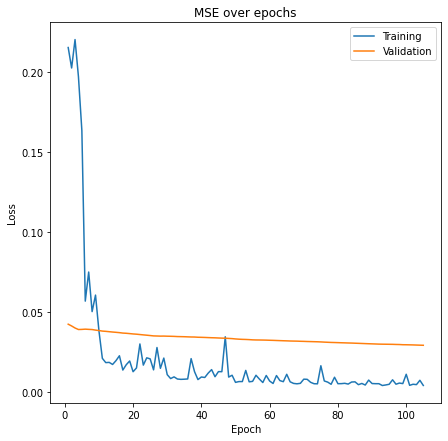

In [ ]:
idx = 2
utils.plot_loss(df0.iloc[idx].valid_losses, df0.iloc[idx].test_losses, start=0, end=None)

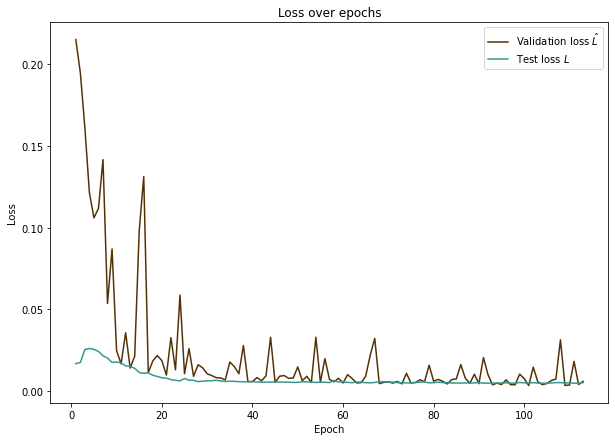

In [ ]:
valid_lossesplot = df.iloc[1]['valid_losses']
test_lossesplot = df.iloc[1]['test_losses']

start = 0

_, ax = plt.subplots(1,1,figsize=(10,7))

x = np.arange(len(valid_lossesplot[start:]))+1

ax.set_title('Loss over epochs')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

colors = plt.cm.BrBG(np.linspace(0, 0.8, 2))

ax.plot(x, valid_lossesplot[start:], label=r'Validation loss $\hat{L}$', color=colors[0])
ax.plot(x, test_lossesplot[start:], label=r'Test loss $L$', color=colors[1])

ax.legend()
plt.savefig('ae_loss')
plt.show()

In [ ]:
loader_iter = iter(test_loader32)
model = models[1][1]

label tensor([0.2344, 0.2344, 0.4219, 0.1562], dtype=torch.float64)
prediction tensor([0.2298, 0.2314, 0.4140, 0.1503], dtype=torch.float64)


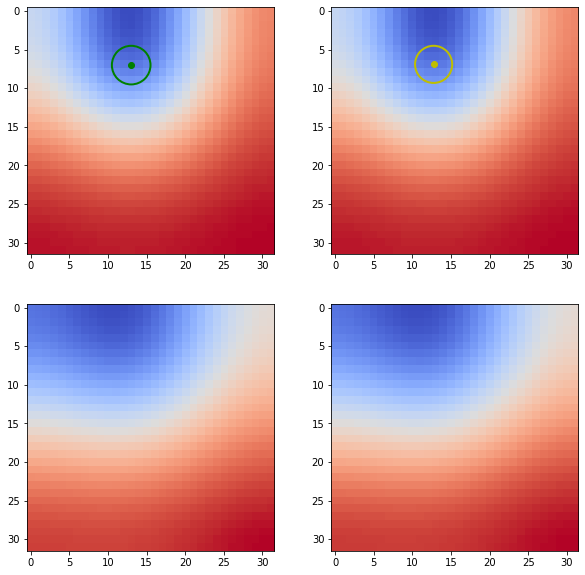

In [ ]:
x,y = next(loader_iter)
with torch.no_grad():
    l, x_hat, y_hat = model(x)
    
print('label', y[0])
print('prediction', y_hat[0])
    
_, axs = plt.subplots(2,2, figsize=(10,10))
axs[0,0].imshow(x[0][0], cmap='coolwarm')
axs[1,0].imshow(x[0][-1], cmap='coolwarm')
axs[0,1].imshow(x_hat[0][0], cmap='coolwarm')
axs[1,1].imshow(x_hat[0][-1], cmap='coolwarm')

n = x.shape[-1]

_,y,z,d = y[0]
axs[0,0].plot(z*n-.5, y*n-.5, 'go', ms = 6, mfc = 'g')
c1 = plt.Circle((z*n-.5, y*n-.5), d*n/2, color='g', fill=False, lw=2)
axs[0,0].add_patch(c1)

_,y,z,d = y_hat[0]
axs[0,1].plot(z*n-.5, y*n-.5, 'yo', ms = 6, mfc = 'y')
c2 = plt.Circle((z*n-.5, y*n-.5), d*n/2, color='y', fill=False, lw=2)
axs[0,1].add_patch(c2)

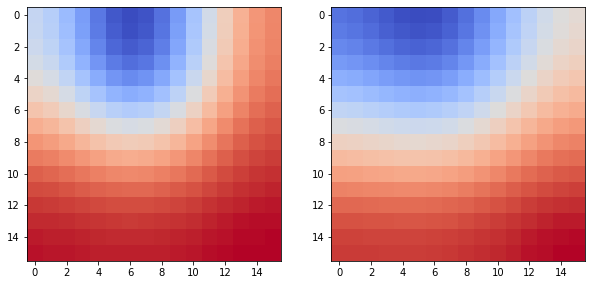

In [ ]:
_, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].imshow(l[0][0], cmap='coolwarm')
axs[1].imshow(l[0][1], cmap='coolwarm')

In [ ]:
convnet_orig = torch.load('./models/convnet32_2.model')
convnet_orig2 = torch.load('./models/convnet32_3.model')

In [ ]:
predictor = nn.Sequential(
    model.encoder,
    convnet_orig2
)
ev = utils.Evaluator(predictor, dataset=test_loader32.dataset.data)
ev.calculate_loss()

0.03505374367751805

In [ ]:
test_ev = utils.Evaluator(predictor, dataset=test_data)
test_ev.calculate_loss()

0.004869489739309137

true: [0.265625 0.234375 0.6875   0.0625  ]
prediction: [0.20891773 0.21039688 0.73694876 0.07210455]


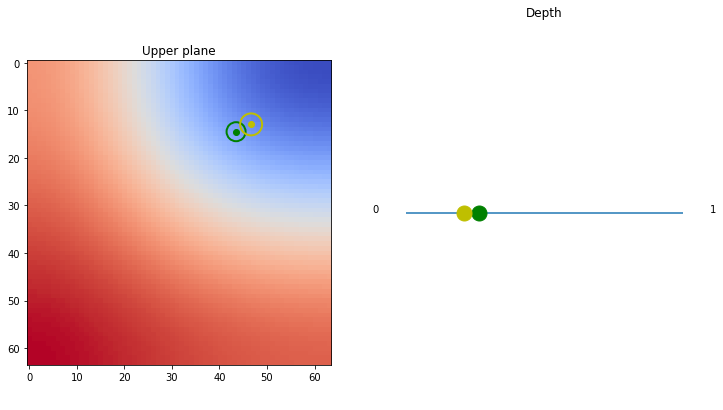

In [ ]:
test_ev.plot_next()

In [ ]:
predictor2 = nn.Sequential(
    model.encoder,
    model.regressor
)
ev = utils.Evaluator(predictor2, dataset=test_loader32.dataset.data)
ev.calculate_loss()

0.0013476770674266377

In [ ]:
test_ev = utils.Evaluator(predictor2, dataset=test_data)
test_ev.calculate_loss()

0.07625786034401716

In [ ]:
test_predictor = nn.Sequential(
    nn.AvgPool2d(kernel_size=2, stride=2),
    convnet_orig2
)

test_ev2 = utils.Evaluator(test_predictor, dataset=test_data)
test_ev2.calculate_loss()

0.02325101620671195

In [ ]:
loader_iter32 = iter(test_loader32)
loader_iter64 = iter(test_loader)

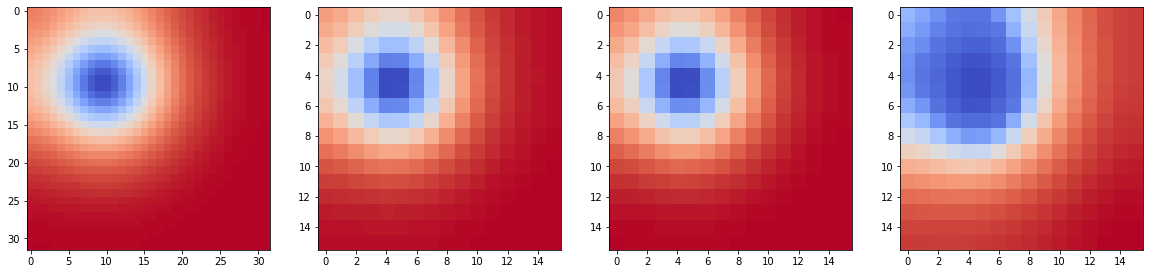

In [ ]:
downsample = nn.AvgPool2d(kernel_size=2, stride=2)

x,y = next(loader_iter32)

with torch.no_grad():
    x_hat = model.encoder.blocks[0](x)
    down = downsample(x)
    res = x_hat-down
    
_, axs = plt.subplots(1,4, figsize=(20,5))
axs[0].imshow(x[0][0], cmap='coolwarm')
axs[1].imshow(x_hat[0][0], cmap='coolwarm')
axs[2].imshow(down[0][0], cmap='coolwarm')
axs[3].imshow(res[0][0], cmap='coolwarm')

In [ ]:
x_hat[0][0][-1],down[0][0][-1],res[0][0][-1]

(tensor([0.5026, 0.5008, 0.4970, 0.4919, 0.4843, 0.4746, 0.4621, 0.4476, 0.4314,
         0.4155, 0.4016, 0.3940, 0.3884, 0.3851, 0.3839, 0.3834],
        dtype=torch.float64),
 tensor([0.4528, 0.4524, 0.4510, 0.4491, 0.4458, 0.4414, 0.4351, 0.4278, 0.4190,
         0.4103, 0.4019, 0.3954, 0.3907, 0.3879, 0.3869, 0.3864],
        dtype=torch.float64),
 tensor([ 0.0499,  0.0484,  0.0460,  0.0428,  0.0385,  0.0332,  0.0270,  0.0199,
          0.0123,  0.0052, -0.0003, -0.0015, -0.0023, -0.0028, -0.0030, -0.0030],
        dtype=torch.float64))

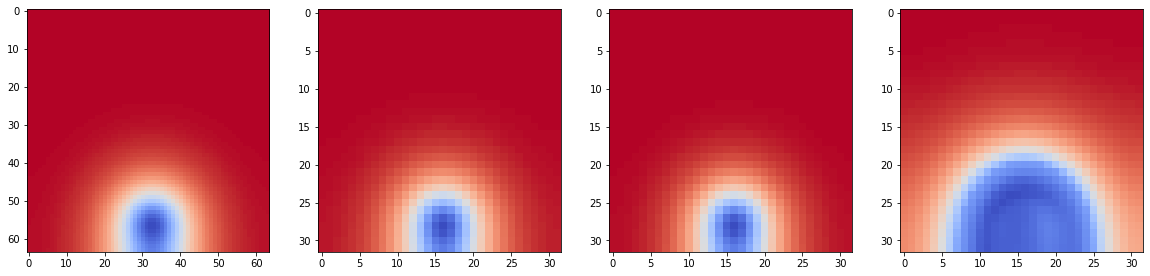

In [ ]:
downsample = nn.AvgPool2d(kernel_size=2, stride=2)

x,y = next(loader_iter64)

with torch.no_grad():
    x_hat = model.encoder.blocks[0](x)
    down = downsample(x)
    res = x_hat-down
    
_, axs = plt.subplots(1,4, figsize=(20,5))
axs[0].imshow(x[0][0], cmap='coolwarm')
axs[1].imshow(x_hat[0][0], cmap='coolwarm')
axs[2].imshow(down[0][0], cmap='coolwarm')
axs[3].imshow(res[0][0], cmap='coolwarm')

In [ ]:
x_hat[0][0][-1],down[0][0][-1],res[0][0][-1]

(tensor([ 0.4311,  0.4274,  0.4181,  0.4036,  0.3814,  0.3492,  0.3029,  0.2396,
          0.1594,  0.0517, -0.0912, -0.2687, -0.4775, -0.7054, -0.9193, -1.0755,
         -1.1330, -1.0738, -0.9157, -0.7010, -0.4729, -0.2639, -0.0885,  0.0509,
          0.1587,  0.2387,  0.3034,  0.3490,  0.3799,  0.4005,  0.4129,  0.4171],
        dtype=torch.float64),
 tensor([ 0.3917,  0.3893,  0.3823,  0.3713,  0.3543,  0.3290,  0.2916,  0.2378,
          0.1620,  0.0579, -0.0808, -0.2567, -0.4666, -0.6951, -0.9090, -1.0654,
         -1.1235, -1.0654, -0.9090, -0.6951, -0.4666, -0.2567, -0.0808,  0.0576,
          0.1617,  0.2372,  0.2907,  0.3278,  0.3528,  0.3692,  0.3789,  0.3826],
        dtype=torch.float64),
 tensor([ 0.0394,  0.0382,  0.0358,  0.0323,  0.0271,  0.0201,  0.0113,  0.0018,
         -0.0026, -0.0063, -0.0104, -0.0120, -0.0109, -0.0103, -0.0103, -0.0101,
         -0.0095, -0.0084, -0.0067, -0.0059, -0.0063, -0.0073, -0.0077, -0.0067,
         -0.0030,  0.0015,  0.0127,  0.0212,  0